In [2]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from itertools import chain, combinations
import statsmodels.api as sm

pd.set_option('display.max_rows', 12)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:20,.2f}'.format)
plt.style.use('seaborn-v0_8')

# Best Subset Selection

In [3]:
hitter = pd.read_csv('Hitters.csv', index_col=0).dropna()
hitter.index.name = 'Player'

hitter  = hitter.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]]
hitter['League'] = pd.get_dummies(hitter['League']).iloc[:, 0]
hitter['Division'] = pd.get_dummies(hitter['Division']).iloc[:, 0]
hitter['NewLeague'] = pd.get_dummies(hitter['NewLeague']).iloc[:, 0]

x = hitter.iloc[:, 0:19]
y = hitter.iloc[:, 19]

In [4]:
k_features = 1

sub = []
reg = []
kft = []

n_features = x.shape[1]

for k_features in range(1, 20):
    subsets = chain(combinations(range(n_features), k_features))

    best_score = np.inf
    
    for subset in subsets:
        lin_reg = sm.OLS(y, sm.add_constant(x.iloc[:, list(subset)])).fit()
        score = lin_reg.ssr
        if score < best_score:
            best_score = score
            best_subset = list(subset)
            best_reg = lin_reg
            
    sub.append(best_subset)
    reg.append(best_reg)
    kft.append(k_features)
    
results = pd.DataFrame({'ktf': kft, 'sub': sub, 'reg': reg},
                       columns=['ktf', 'sub', 'reg']).set_index('ktf')

In [5]:
results = pd.read_pickle('results_651')

<AxesSubplot: title={'center': 'BIC'}, xlabel='kft'>

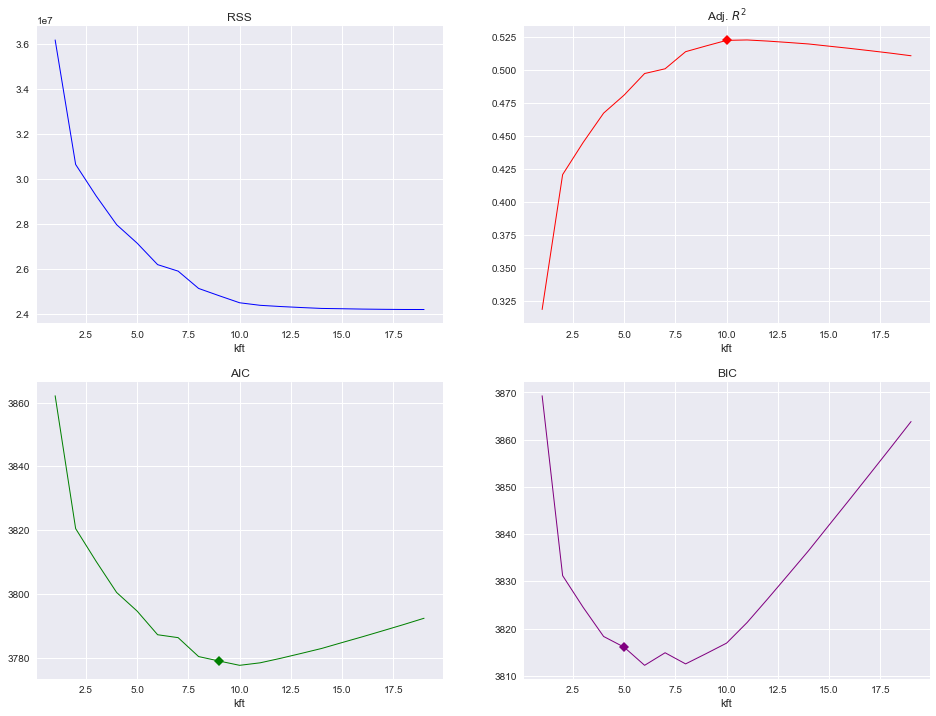

In [6]:
plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
results.rss.plot(title='RSS', lw=1, color='blue')

plt.subplot(2,2,2)
max_r2a = results.r2a.argmax() - 1
results.r2a.plot(title='Adj. $R^2$', lw=1, color='red', marker='D', markevery=[max_r2a])

plt.subplot(2,2,3)
min_aic = results.aic.argmin() - 1
results.aic.plot(title='AIC', lw=1, color='green', marker='D', markevery=[min_aic])

plt.subplot(2,2,4)
min_bic = results.bic.argmin() - 1
results.bic.plot(title='BIC', lw=1, color='purple', marker='D', markevery=[min_bic])

# Forward and Backward Stepwise Selection

In [41]:
def processSubset(feature_set):
    model = sm.OLS(y, x[list(feature_set)])
    regr = model.fit()
    RSS = regr.ssr
    return {'model': regr, 'RSS': RSS}

def forward(predictor):
    remaining_predictors = [p for p in x.columns if p not in predictor]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictor + [p]))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    return best_model

def backward(predictors):
    results = []
    
    for combo in combinations(predictors, len(predictors) - 1):
        results.append(processSubset(combo))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    return best_model

In [42]:
models2 = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1, len(x.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]['model'].model.exog_names
    
bic_f = []

for m in models2.model:
    bic_f.append(m.bic)

np.array(bic_f).argmin()

5

In [43]:
predictors, bic_f

(['Hits',
  'CRBI',
  'PutOuts',
  'AtBat',
  'Division',
  'Walks',
  'CWalks',
  'CRuns',
  'CAtBat',
  'Assists',
  'Runs',
  'League',
  'HmRun',
  'Errors',
  'NewLeague',
  'RBI',
  'CHits',
  'Years',
  'CHmRun'],
 [3910.437405792022,
  3826.372838539718,
  3820.626997734044,
  3815.4605878697303,
  3810.7331322124824,
  3806.8883425646886,
  3809.8597898274984,
  3807.1870192596657,
  3809.3387521975437,
  3811.923580691154,
  3816.5713995697747,
  3821.5191822804245,
  3826.8028102714034,
  3832.1077814957293,
  3837.456294954363,
  3842.8214798303275,
  3848.225835229507,
  3853.720486189592,
  3859.2816820271046])

In [44]:
models3 = pd.DataFrame(columns=['RSS', 'model'], index=range(1, len(x.columns)))

predictors = x.columns

while(len(predictors)>1):
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]['model'].model.exog_names
    
bic_b = []

for m in models3.model:
    bic_b.append(m.bic)
    
np.array(bic_b).argmin()

7

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)

In [46]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    model = sm.OLS(y_train, X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'model': regr, 'RSS': RSS}

def forward(predictors, X_train, y_train, X_test, y_test):
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors + [p], X_train, y_train, X_test, y_test))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    return best_model

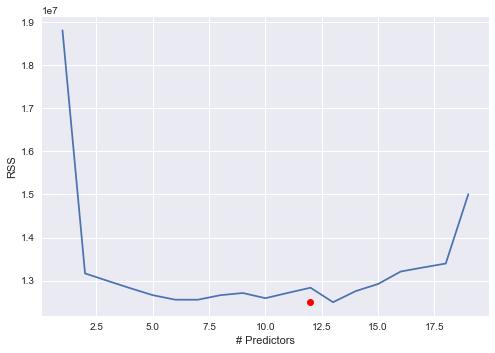

In [51]:
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1, len(x.columns)+1):
    models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

plt.plot(models_train['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(pd.to_numeric(models_train['RSS']).argmin(), models_train['RSS'].min(), 'or')

# Ridge Regression

In [19]:
hitter = pd.read_csv('Hitters.csv', index_col=0).dropna()
hitter.index.name = 'Player'

hitter = hitter.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,15,17,19,18]]

hitter['League'] = pd.get_dummies(hitter['League']).iloc[:, 1]
hitter['Division'] = pd.get_dummies(hitter['Division']).iloc[:, 1]
hitter['NewLeague'] = pd.get_dummies(hitter['NewLeague']).iloc[:, 1]

X = hitter.iloc[:, 0:19]
y = hitter.iloc[:, 19]

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

grid = 10 ** np.linspace(10, -2, 100)
ridge_model = Ridge()
coefs = []

for a in grid:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(scale(X), y)
    coefs.append(ridge_model.coef_)

In [21]:
pd.Series(coefs[49], index=X.columns)

AtBat                       3.49
Hits                        3.95
HmRun                       2.98
Runs                        3.75
RBI                         3.98
                    ...         
Division                   -1.88
Assists                     0.24
PutOuts                     2.84
Errors                     -0.07
NewLeague                   0.05
Length: 19, dtype: float64

Text(0, 0.5, 'weights')

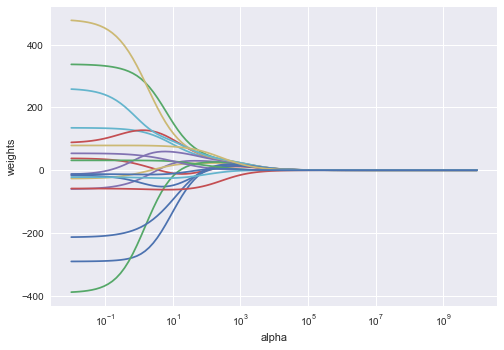

In [22]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(scale(X), y, test_size=0.5, random_state=1)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

ridge2 = Ridge(alpha=4)
ridge2_fit = ridge2.fit(scaler.transform(X_train), y_train)
y_pred2 = ridge2.predict(scaler.transform(X_test))

print(pd.Series(ridge2_fit.coef_, index=X.columns))
print('MSE: ', mean_squared_error(y_test, y_pred2))

AtBat                    -210.81
Hits                      193.08
HmRun                     -51.44
Runs                        1.62
RBI                        81.46
                    ...         
Division                  -60.25
Assists                    25.56
PutOuts                   125.56
Errors                    -18.52
NewLeague                 -18.65
Length: 19, dtype: float64
MSE:  102144.52395076495


In [25]:
ridge3 = Ridge(alpha=1e10)
ridge3_fit = ridge3.fit(scaler.transform(X_train), y_train)
y_pred3 = ridge3.predict(scaler.transform(X_test))

print(pd.Series(ridge3_fit.coef_, index=X.columns))
print('MSE: ', mean_squared_error(y_test, y_pred3))

AtBat                       0.00
Hits                        0.00
HmRun                       0.00
Runs                        0.00
RBI                         0.00
                    ...         
Division                   -0.00
Assists                    -0.00
PutOuts                     0.00
Errors                      0.00
NewLeague                  -0.00
Length: 19, dtype: float64
MSE:  172862.22059245987


In [26]:
ridge4 = Ridge(alpha=0)
ridge4_fit = ridge4.fit(scaler.transform(X_train), y_train)
y_pred4 = ridge4.predict(scaler.transform(X_test))

print(pd.Series(ridge4_fit.coef_, index=X.columns))
print('MSE: ', mean_squared_error(y_test, y_pred4))

AtBat                    -266.55
Hits                      197.71
HmRun                     -38.10
Runs                       -1.01
RBI                       103.12
                    ...         
Division                  -56.87
Assists                    65.82
PutOuts                   126.08
Errors                    -38.31
NewLeague                 -40.96
Length: 19, dtype: float64
MSE:  116690.4685666025


In [27]:
ridge_cv = RidgeCV(alphas=grid, scoring='neg_mean_squared_error')
ridge_cv.fit(scaler.transform(X_train), y_train)
ridge_cv.alpha_

75.64633275546291

In [28]:
ridge5 = Ridge(alpha=ridge_cv.alpha_)
ridge5_fit = ridge5.fit(scaler.transform(X_train), y_train)
y_pred5 = ridge5.predict(scaler.transform(X_test))

print(pd.Series(ridge5_fit.coef_, index=X.columns))
print('MSE: ', mean_squared_error(y_test, y_pred5))

AtBat                      -1.88
Hits                       40.04
HmRun                      -2.26
Runs                       18.79
RBI                        34.08
                    ...         
Division                  -46.02
Assists                    -2.45
PutOuts                    83.79
Errors                     -1.99
NewLeague                   4.97
Length: 19, dtype: float64
MSE:  99820.74305168976


# Lasso

In [29]:
from sklearn.preprocessing import scale

grid = 10 ** np.linspace(10, -2, 100)

lasso_model = Lasso(max_iter=10000)
coefs = []

for a in grid:
    lasso_model.set_params(alpha=a)
    lasso_model.fit(scaler.transform(X_train), y_train)
    coefs.append(lasso_model.coef_)

Text(0, 0.5, 'weights')

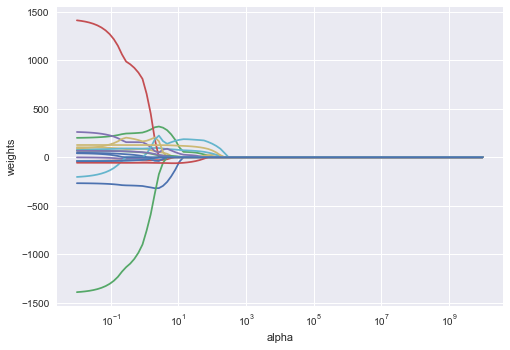

In [30]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [31]:
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=100000)
lasso_cv.fit(scaler.transform(X_train), y_train)
lasso_cv.alpha_

27.503283261878394

In [32]:
lasso2 = Lasso(max_iter=10000, alpha=lasso_cv.alpha_)
lasso2_fit = lasso2.fit(scaler.transform(X_train), y_train)
y_pred2 = lasso2.predict(scaler.transform(X_test))

print(pd.Series(lasso2_fit.coef_, index=X.columns))
print('MSE: ', mean_squared_error(y_test, y_pred2))

AtBat                       0.00
Hits                       50.25
HmRun                       0.00
Runs                        0.00
RBI                         0.00
                    ...         
Division                  -44.53
Assists                    -0.00
PutOuts                   110.31
Errors                     -0.00
NewLeague                   0.00
Length: 19, dtype: float64
MSE:  104960.66099408537


# Principal Components Regression

In [33]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

pca = PCA()
X_pca = pca.fit_transform(scale(X))
pd.DataFrame(X_pca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.01,1.87,1.27,-0.94,1.11,1.21,-0.07,-0.10,-0.25,-0.64,0.46,0.62,-0.48,0.39,0.06,0.14,0.08,0.04,-0.02
1,0.41,-2.43,-0.91,-0.26,1.23,1.83,0.36,-1.20,-0.37,0.02,0.18,0.08,0.40,-0.02,0.07,0.16,0.04,0.01,-0.00
2,3.47,0.83,0.56,-1.62,-0.86,-1.03,-1.00,0.84,0.20,0.77,0.06,0.10,0.02,-0.38,0.23,0.01,-0.22,0.04,-0.07
3,-2.56,-0.23,0.52,-2.18,-0.82,1.49,-0.28,0.21,0.41,0.14,-0.09,-0.15,0.14,0.03,0.04,0.05,-0.04,0.01,-0.01
4,1.03,-1.57,1.33,3.49,0.98,0.51,0.14,0.99,-0.66,-0.22,0.11,0.19,-0.30,-0.09,0.04,0.01,-0.05,0.13,-0.07


Text(0, 0.5, 'RMSE')

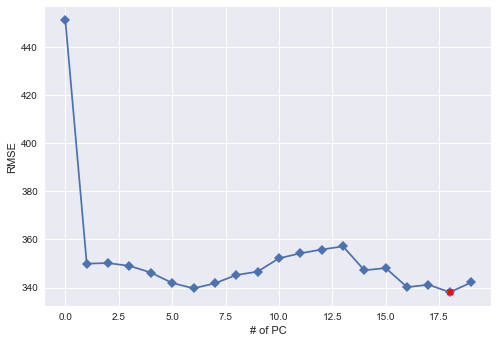

In [34]:
n = len(X_pca)
k10 = KFold(n_splits=10, shuffle=True, random_state=1)

lin_reg = LinearRegression()
rmse = []

score = -1 * cross_val_score(lin_reg, np.ones((n, 1)), y, cv=k10, scoring='neg_mean_squared_error').mean()
rmse.append(np.sqrt(score))

for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg, X_pca[:, :i], y, cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))

min_rmse = np.array(rmse).argmin()

plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')

# Partial Least Squares

([<matplotlib.axis.XTick at 0x7fe68b7f4580>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

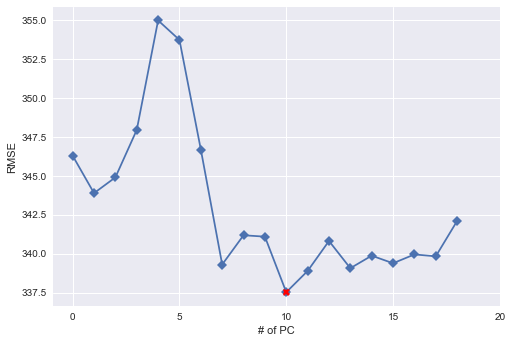

In [35]:
n = len(X_pca)
k10 = KFold(n_splits=10, shuffle=True, random_state=1)

rmse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, scale(X), y, cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()

plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0,5,10,15,20])

In [36]:
pls = PLSRegression(n_components=2)
pls.fit(scaler.transform(X_train), y_train)

mean_squared_error(y_test, pls.predict(scaler.transform(X_test)))

102583.13156134984